In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

from going_modular.going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves


c:\Users\MANOJ M\OneDrive\Documents\Torch\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] data\pizza_steak_sushi_20_percent directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi_20_percent')

In [4]:
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

In [5]:
effnetb2_weights=torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2_transforms = effnetb2_weights.transforms()
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights) 
for param in effnetb2.parameters():
    param.requires_grad = False

In [6]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [7]:
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, 
              out_features=3)) 

In [8]:
def create_effnetb2_model(num_classes:int=3, 
                          seed:int=42):
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    for param in model.parameters():
        param.requires_grad = False

    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    
    return model, transforms

In [9]:
from torchinfo import summary

summary(effnetb2, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [10]:
from going_modular.going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

In [11]:

from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)


 10%|█         | 1/10 [00:26<03:55, 26.14s/it]

Epoch: 1 | train_loss: 0.9583 | train_acc: 0.5833 | test_loss: 0.7196 | test_acc: 0.9347


 20%|██        | 2/10 [00:51<03:25, 25.67s/it]

Epoch: 2 | train_loss: 0.6827 | train_acc: 0.8542 | test_loss: 0.5906 | test_acc: 0.9443


 30%|███       | 3/10 [01:20<03:09, 27.14s/it]

Epoch: 3 | train_loss: 0.5733 | train_acc: 0.8917 | test_loss: 0.4931 | test_acc: 0.9500


 40%|████      | 4/10 [01:45<02:36, 26.16s/it]

Epoch: 4 | train_loss: 0.4459 | train_acc: 0.9042 | test_loss: 0.4360 | test_acc: 0.9437


 50%|█████     | 5/10 [02:20<02:27, 29.57s/it]

Epoch: 5 | train_loss: 0.4218 | train_acc: 0.9125 | test_loss: 0.3947 | test_acc: 0.9443


 60%|██████    | 6/10 [02:49<01:57, 29.31s/it]

Epoch: 6 | train_loss: 0.4298 | train_acc: 0.8896 | test_loss: 0.3496 | test_acc: 0.9688


 70%|███████   | 7/10 [03:14<01:23, 27.76s/it]

Epoch: 7 | train_loss: 0.4268 | train_acc: 0.8417 | test_loss: 0.3281 | test_acc: 0.9625


 80%|████████  | 8/10 [03:39<00:53, 26.97s/it]

Epoch: 8 | train_loss: 0.3931 | train_acc: 0.9000 | test_loss: 0.3484 | test_acc: 0.9261


 90%|█████████ | 9/10 [04:04<00:26, 26.29s/it]

Epoch: 9 | train_loss: 0.3744 | train_acc: 0.8833 | test_loss: 0.3123 | test_acc: 0.9165


100%|██████████| 10/10 [04:30<00:00, 27.08s/it]

Epoch: 10 | train_loss: 0.3630 | train_acc: 0.8771 | test_loss: 0.2818 | test_acc: 0.9625


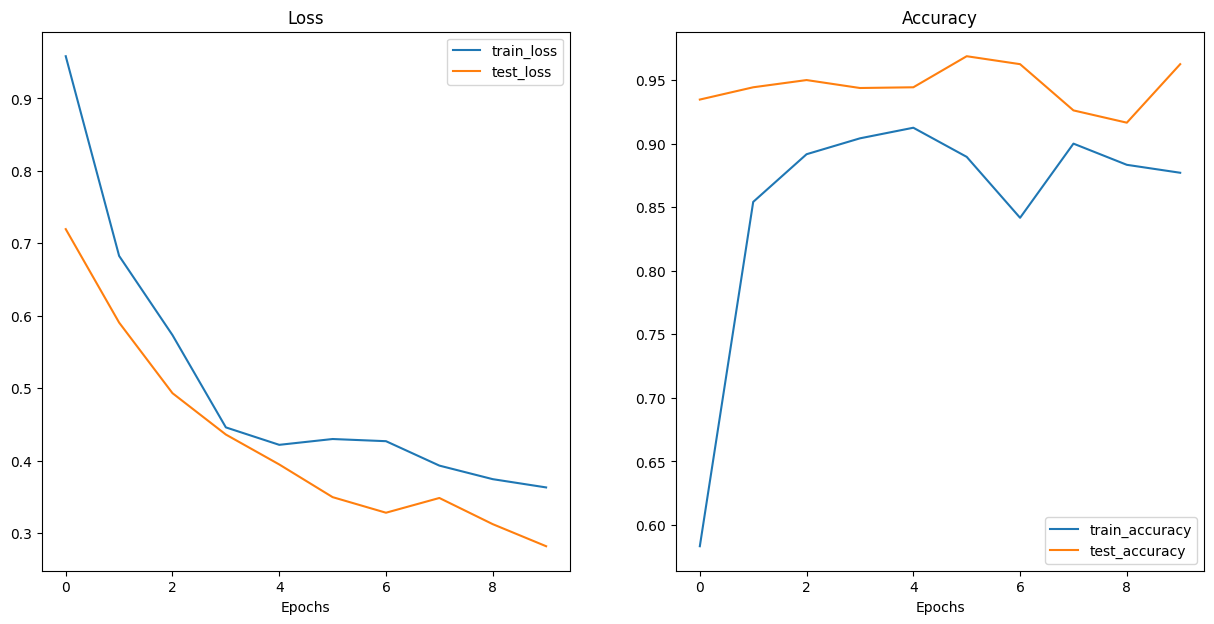

In [12]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

In [13]:
from going_modular.going_modular import utils
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")


[INFO] Saving model to: 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


In [14]:
from pathlib import Path
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) 
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


In [15]:
effnetb2_total_params=sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [16]:
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.2818296283483505,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

In [17]:
vit=torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [18]:
def create_vit_model(num_classes:int=3, 
                     seed:int=42):

    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    for param in model.parameters():
        param.requires_grad = False

    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes
    
    return model, transforms

In [19]:
vit,vit_transforms=create_vit_model(num_classes=3,seed=42)

In [20]:
from torchinfo import summary

summary(vit, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

c:\Users\MANOJ M\OneDrive\Documents\Torch\myenv\lib\site-packages\torch\nn\modules\activation.py:1221: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  return torch._native_multi_head_attention(


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [21]:
from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

In [22]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

 10%|█         | 1/10 [00:52<07:56, 52.91s/it]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381


 20%|██        | 2/10 [01:30<05:52, 44.10s/it]

Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602


 30%|███       | 3/10 [02:06<04:42, 40.39s/it]

Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693


 40%|████      | 4/10 [02:41<03:49, 38.32s/it]

Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722


 50%|█████     | 5/10 [03:17<03:06, 37.26s/it]

Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784


 60%|██████    | 6/10 [03:52<02:26, 36.55s/it]

Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722


 70%|███████   | 7/10 [04:26<01:47, 35.87s/it]

Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784


 80%|████████  | 8/10 [05:01<01:11, 35.54s/it]

Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722


 90%|█████████ | 9/10 [05:36<00:35, 35.26s/it]

Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784


100%|██████████| 10/10 [06:10<00:00, 37.07s/it]

Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


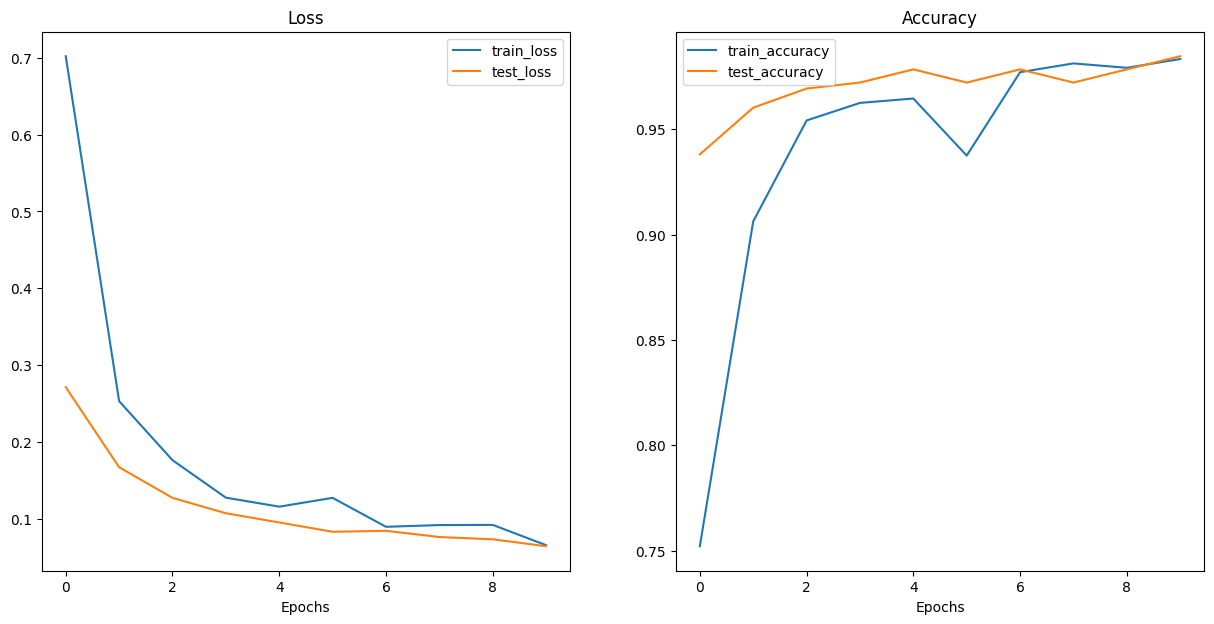

In [23]:

from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

In [24]:
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: 09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


In [25]:
from pathlib import Path

pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


In [26]:
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [27]:
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

vit_stats

{'test_loss': 0.06443448746576905,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

In [28]:
from pathlib import Path

print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: data\pizza_steak_sushi_20_percent\test


[WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1067986.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/129666.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1315645.jpg')]

In [29]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer 
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path], 
                   model: torch.nn.Module,
                   transform: torchvision.transforms, 
                   class_names: List[str], 
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
    
    # 2. Create an empty list to store prediction dictionaires
    pred_list = []
    
    # 3. Loop through target paths
    for path in tqdm(paths):
        
        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name
        
        # 6. Start the prediction timer
        start_time = timer()
        
        # 7. Open image path
        img = Image.open(path)
        
        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device) 
        
        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()
        
        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample 
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on) 
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class
            
            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)
    
    # 15. Return list of prediction dictionaries
    return pred_list


In [30]:
effnetb2_test_pred_dicts=pred_and_store(paths=test_data_paths,
                                        model=effnetb2,
                                        transform=effnetb2_transforms,
                                        class_names=class_names,
                                        device="cpu")#Making Predictions on CPU

100%|██████████| 150/150 [00:38<00:00,  3.89it/s]


In [31]:
effnetb2_test_pred_dicts[:2]

[{'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9952,
  'pred_class': 'pizza',
  'time_for_pred': 0.4967,
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.4499,
  'pred_class': 'pizza',
  'time_for_pred': 0.3018,
  'correct': True}]

In [32]:
import pandas as pd
effnetb2_test_pred_df=pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9952,pizza,0.4967,True
1,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.4499,pizza,0.3018,True
2,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9907,pizza,0.3059,True
3,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.6853,pizza,0.2948,True
4,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.7488,pizza,0.3054,True


In [33]:
effnetb2_test_pred_df.correct.value_counts()

correct
True     144
False      6
Name: count, dtype: int64

In [34]:
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.2557 seconds


In [35]:
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.2818296283483505,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': 0.2557}

In [36]:
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")


100%|██████████| 150/150 [01:12<00:00,  2.08it/s]


In [37]:
vit_test_pred_dicts[:2]


[{'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9987,
  'pred_class': 'pizza',
  'time_for_pred': 0.841,
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9957,
  'pred_class': 'pizza',
  'time_for_pred': 0.4342,
  'correct': True}]

In [38]:
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9987,pizza,0.8410,True
1,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9957,pizza,0.4342,True
2,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9987,pizza,0.4170,True
3,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9869,pizza,0.5580,True
4,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9698,pizza,0.5446,True


In [39]:
vit_test_pred_df.correct.value_counts()


correct
True     148
False      2
Name: count, dtype: int64

In [40]:
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

ViT average time per prediction: 0.4806 seconds


In [41]:
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06443448746576905,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': 0.4806}

In [42]:

# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.281830,96.25,7705221,29,0.2557,EffNetB2
1,0.064434,98.47,85800963,327,0.4806,ViT


In [43]:
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]),
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.228629,1.023065,11.135432,11.275862,1.879546


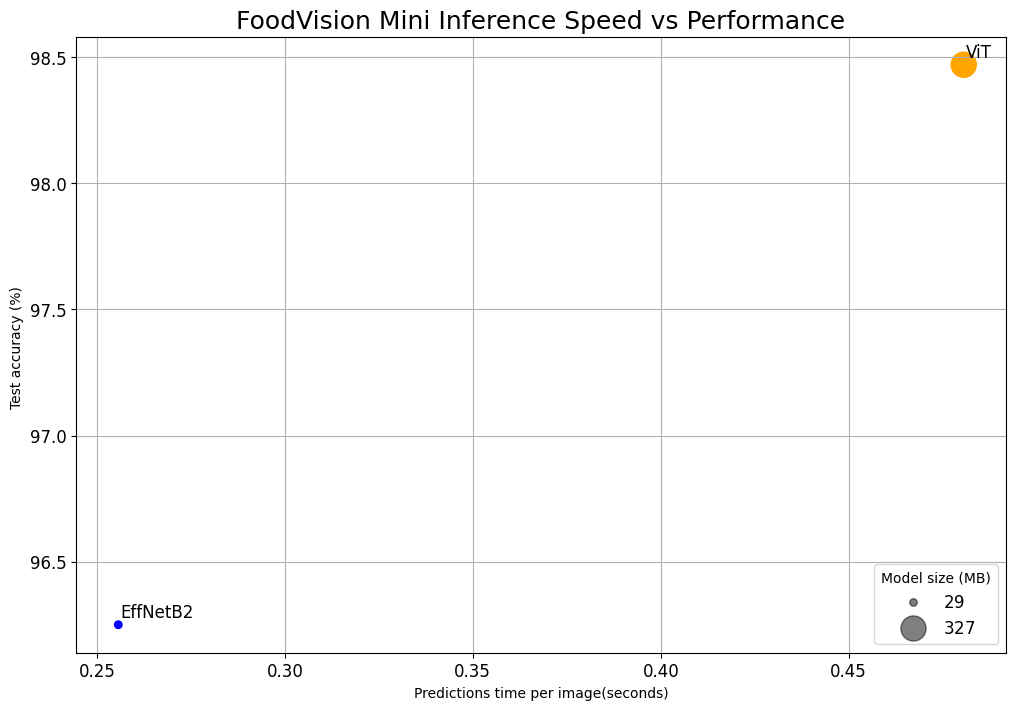

In [44]:
fig,ax=plt.subplots(figsize=(12,8))
scatter=ax.scatter(data=df,
                   x="time_per_pred_cpu",
                   y="test_acc",
                   c=["blue","orange"],
                   s="model_size (MB)")
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Predictions time per image(seconds)")
ax.set_ylabel("Test accuracy (%) ")
ax.tick_params(axis='both',labelsize=12)
ax.grid(True)
for index, row in df.iterrows():
    ax.annotate(text=row["model"], # note: depending on your version of Matplotlib, you may need to use "s=..." or "text=...", see: https://github.com/faustomorales/keras-ocr/issues/183#issuecomment-977733270 
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles, 
                              labels, 
                              loc="lower right", 
                              title="Model size (MB)",
                              fontsize=12)

# !mdkir images/
plt.savefig("images/09-foodvision-mini-inference-speed-vs-performance.jpg")

plt.show()

In [45]:
try:
    import gradio as gr
except: 
    !pip -q install gradio
    import gradio as gr
    
print(f"Gradio version: {gr.__version__}")

Gradio version: 4.36.1


In [46]:
effnetb2.to("cpu")
next(iter(effnetb2.parameters())).device

device(type='cpu')

In [47]:
from typing import Tuple,Dict
def predict(img) -> Tuple[Dict,float] :
    start_time=timer()
    img=effnetb2_transforms(img).unsqueeze(0)
    effnetb2.eval()
    with torch.inference_mode():
        pred_probs=torch.softmax(effnetb2(img),dim=1)
    pred_labels_and_probs={class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    pred_time=round(timer()-start_time,5)
    return pred_labels_and_probs,pred_time

In [48]:
import random
from PIL import Image
test_data_paths=list(Path(test_dir).glob("*/*.jpg"))
random_image_path=random.sample(test_data_paths,k=1)[0]
image=Image.open(random_image_path)
print(f"[INFO] Predicting on image at path : {random_image_path}\n")
pred_dict,pred_time=predict(img=image)
print(f"Prediction label and probability dictionary : \n {pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path : data\pizza_steak_sushi_20_percent\test\sushi\124279.jpg

Prediction label and probability dictionary : 
 {'pizza': 0.17302344739437103, 'steak': 0.19977183640003204, 'sushi': 0.6272047162055969}
Prediction time: 0.2837 seconds


In [49]:
example_list=[[str(filepath)] for filepath in random.sample(test_data_paths,k=3)]
example_list

[['data\\pizza_steak_sushi_20_percent\\test\\sushi\\472912.jpg'],
 ['data\\pizza_steak_sushi_20_percent\\test\\pizza\\3486640.jpg'],
 ['data\\pizza_steak_sushi_20_percent\\test\\steak\\3173402.jpg']]

In [50]:
import gradio as gr
title="FoodVision Mini"
description="An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

demo=gr.Interface(fn=predict,inputs=gr.Image(type='pil'),
                  outputs=[gr.Label(num_top_classes=3,label="Predictions"),
                           gr.Number(label="Prediction time (s)")],
                           examples=example_list,
                           title=title,
                           description=description,
                           article=article)
demo.launch(debug=False,
            share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://8b21ab1bc2a85c4e9c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [51]:
import shutil
from pathlib import Path
foodvision_mini_demo_path=Path("demos/foodvision_mini/")
if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)
    foodvision_mini_demo_path.mkdir(parents=True,
                                    exist_ok=True)
else:
    foodvision_mini_demo_path.mkdir(parents=True,
                                    exist_ok=True)
!dir demos/foodvision_mini/

Invalid switch - "foodvision_mini".


In [52]:
import shutil
from pathlib import Path
foodvision_mini_examples_path=foodvision_mini_demo_path/"examples"
foodvision_mini_examples_path.mkdir(parents=True,
                                    exist_ok=True)
foodvision_mini_examples=[Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]
for example in foodvision_mini_examples:
    destination=foodvision_mini_examples_path/example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example,dst=destination)

[INFO] Copying data\pizza_steak_sushi_20_percent\test\sushi\592799.jpg to demos\foodvision_mini\examples\592799.jpg
[INFO] Copying data\pizza_steak_sushi_20_percent\test\steak\3622237.jpg to demos\foodvision_mini\examples\3622237.jpg
[INFO] Copying data\pizza_steak_sushi_20_percent\test\pizza\2582289.jpg to demos\foodvision_mini\examples\2582289.jpg


In [53]:
import os
example_list=[["examples/" +example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/2582289.jpg'], ['examples/3622237.jpg'], ['examples/592799.jpg']]

In [54]:
import shutil

# Create a source path for our target model
effnetb2_foodvision_mini_model_path = "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

# Create a destination path for our target model 
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")
    
    # Move the model
    shutil.move(src=effnetb2_foodvision_mini_model_path, 
                dst=effnetb2_foodvision_mini_model_destination)
    
    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")


[INFO] Attempting to move models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos\foodvision_mini\09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] Model move complete.


In [55]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3, 
                          seed:int=42):
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    for param in model.parameters():
        param.requires_grad = False

    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    
    return model, transforms

Writing demos/foodvision_mini/model.py


In [56]:
%%writefile demos/foodvision_mini/app.py

import gradio as gr
import os
import torch
from model import create_effnetb2_model
from timeit import default_timer as Timer
from typing import Tuple,Dict
class_names=["pizza","steak","sushi"]
effnetb2,effnetb2_transforms=create_effnetb2_model(num_classes=3)
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu")
    )
)

def predict(img) -> Tuple[Dict,float]:
    start_time = timer()
    img = effnetb2_transforms(img).unsqueeze(0)
    
    effnetb2.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(effnetb2(img), dim=1)
    
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    pred_time = round(timer() - start_time, 5)
    return pred_labels_and_probs, pred_time


title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

example_list = [["examples/" + example] for example in os.listdir("examples")]

demo = gr.Interface(fn=predict, 
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), 
                             gr.Number(label="Prediction time (s)")], 
                    examples=example_list, 
                    title=title,
                    description=description,
                    article=article)

demo.launch()


Writing demos/foodvision_mini/app.py


In [57]:
%%writefile demos/foodvision_mini/requirements.txt
torch==latest
torchvision==latest
gradio==3.45.0

Writing demos/foodvision_mini/requirements.txt


In [58]:
!dir demos/foodvisiob_mini

Invalid switch - "foodvisiob_mini".


In [59]:
# We require only these files to upload in Huggingface Spaces,
# 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
# app.py
# examples
# model.py
# requirements.txt

In [1]:
import torch

In [3]:
torch.__version__

'2.3.1+cu118'

In [5]:
import torchvision
import gradio
torchvision.__version__,gradio.__version__

c:\Users\MANOJ M\OneDrive\Documents\Torch\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


('0.18.1+cu118', '4.36.1')